In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_Srubed_for_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 122621 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['Nonimmune',"Fibroblasts","Endothelial cells"]), :]
adata

View of AnnData object with n_obs × n_vars = 4052 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [7]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 4052 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group',"CD3D",'CD8A',"SFTPB","AGER","DCN","CSF1R"],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

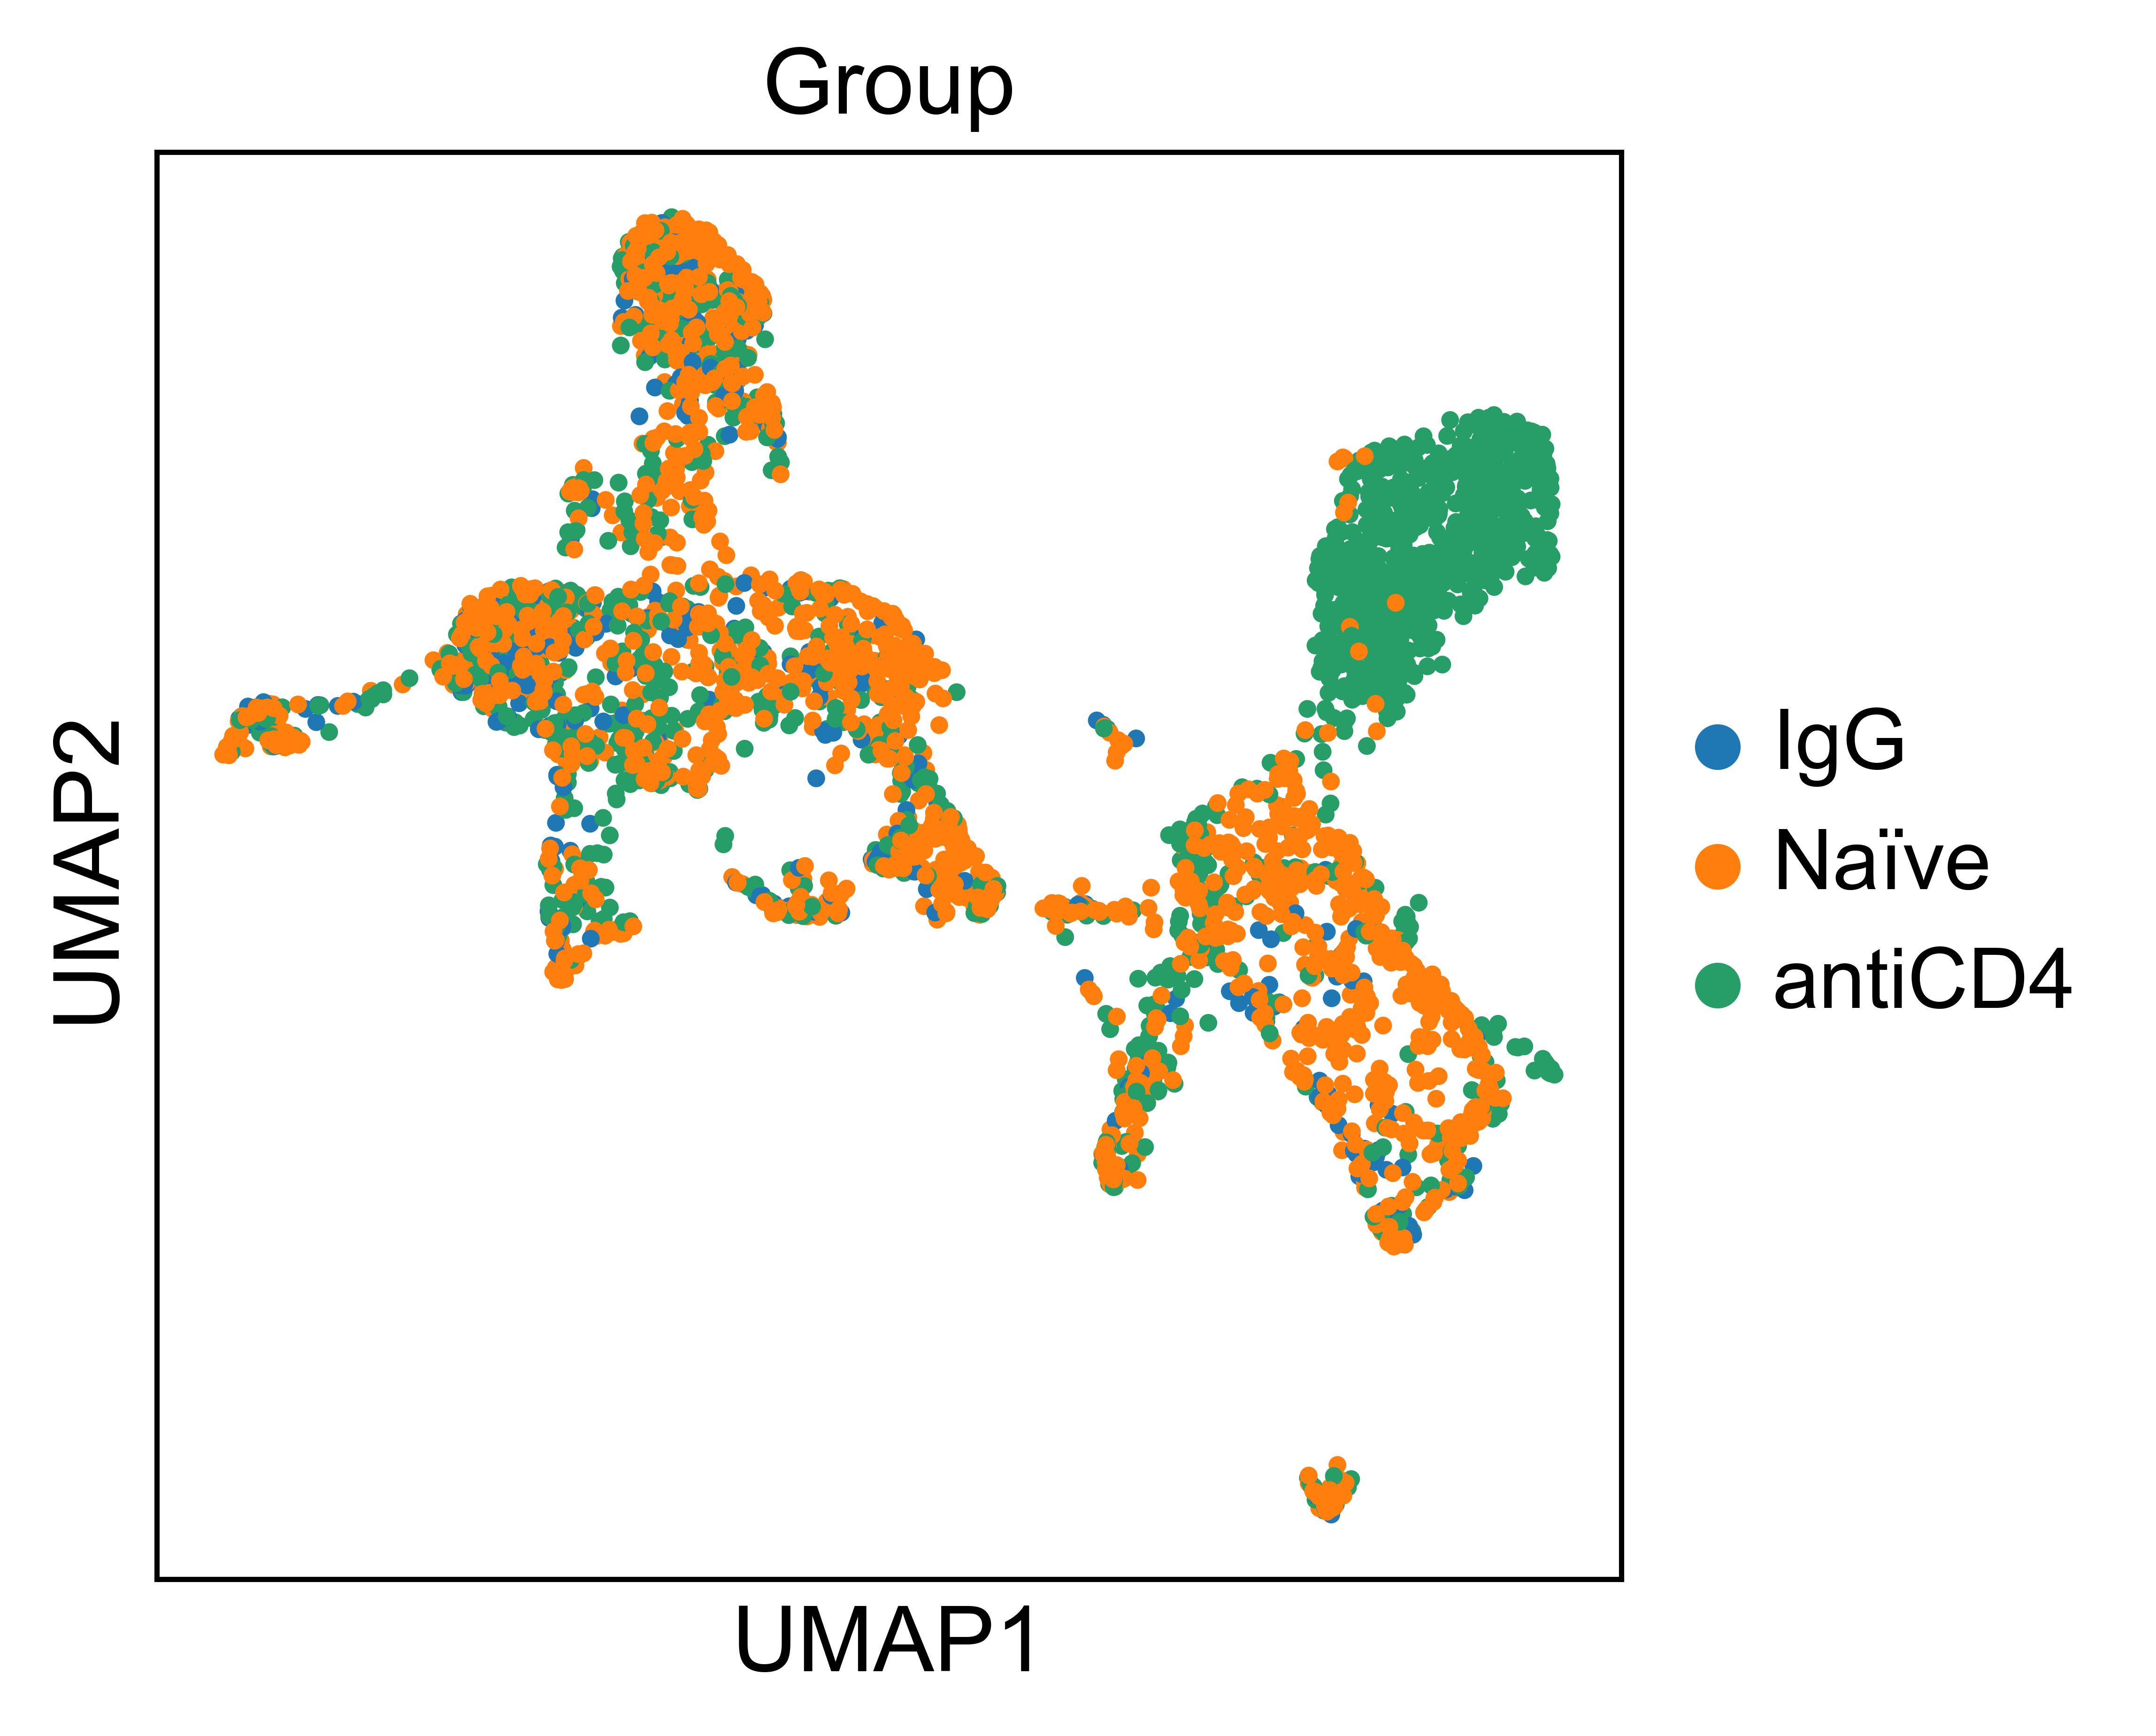

In [9]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=12, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

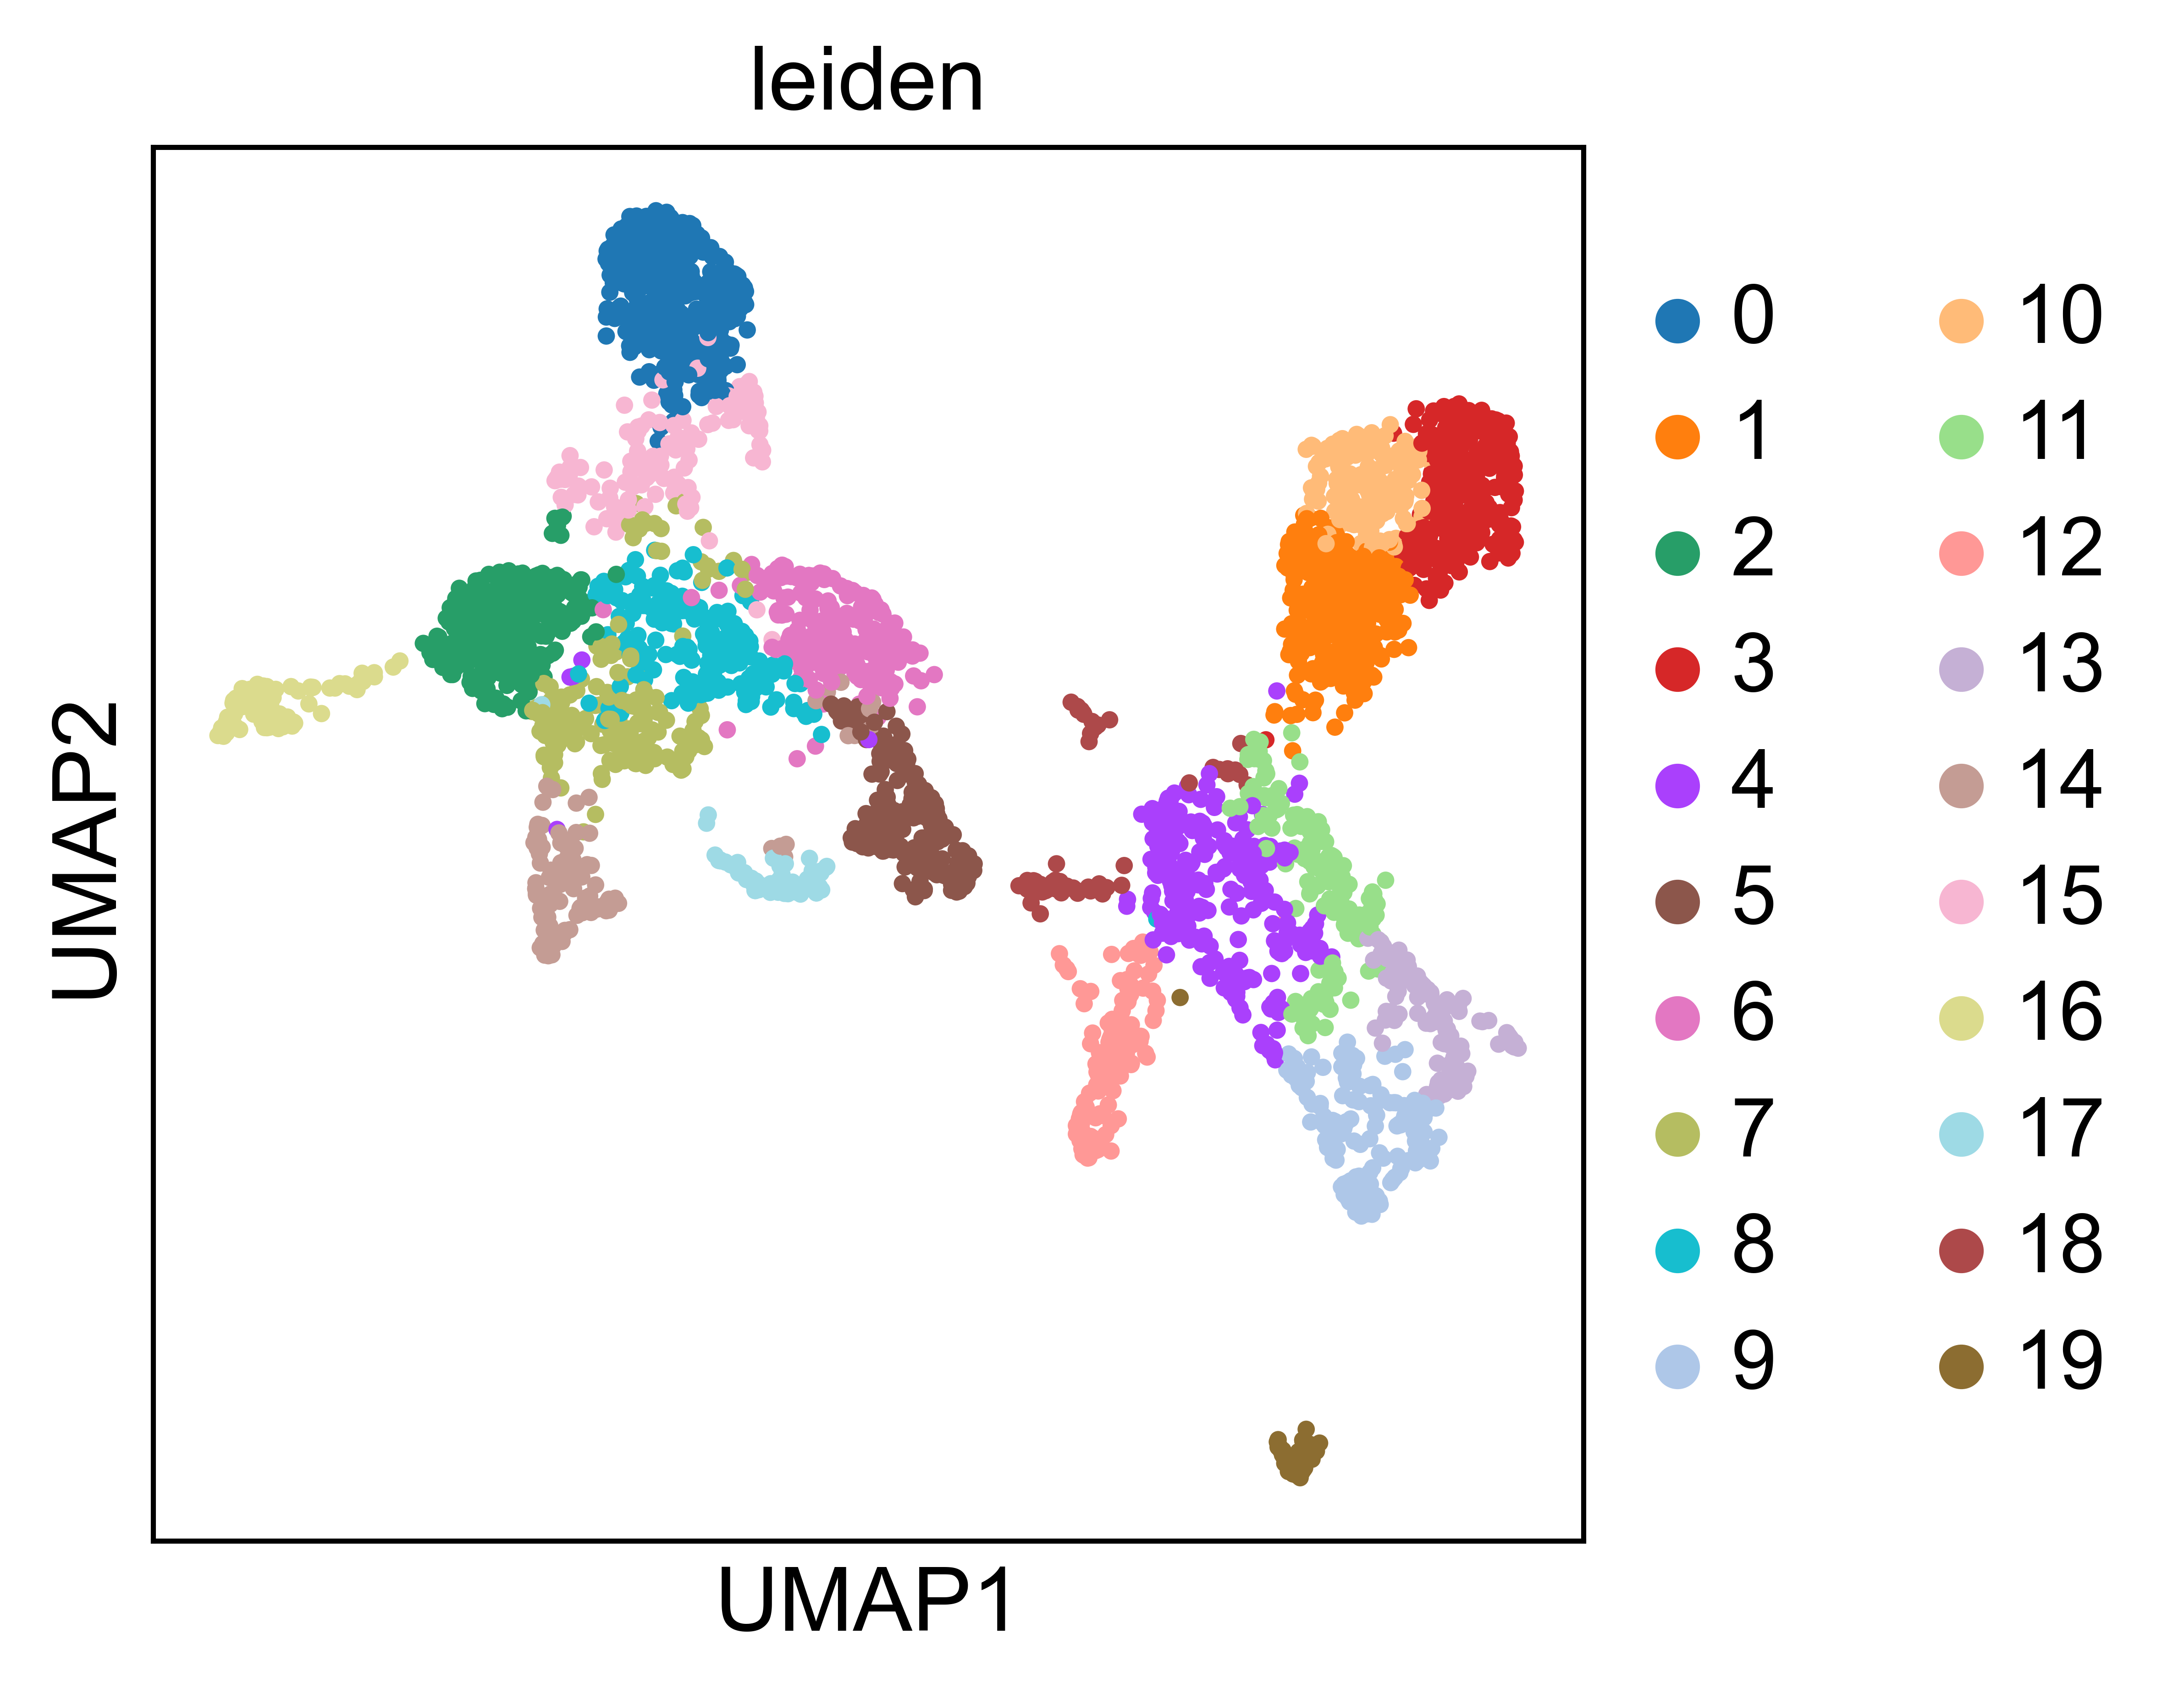

In [17]:
sc.tl.leiden(adata,resolution=1.8)
sc.pl.umap(adata, color = ["leiden"])

In [19]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))


0             1        2             3            4  \
0           HPGD          CPA3     THBD          CPA3          DCN   
1   LOC102128376           LYZ   RNASE1  LOC102142071          MGP   
2         ADGRL2  LOC102142071   SEMA3G           LYZ        TIMP1   
3            KDR  LOC102133296    PTPRB          C1QB         GPX3   
4        TSPAN12          APOE    APLNR         CXCL9         APOE   
5            PRX  LOC107126411     RGS5          APOE          HBB   
6          RAMP3          C1QB     LIFR         APOC1        MFAP4   
7          MYZAP  LOC102128706    EPAS1          C1QA       COL6A3   
8           AQP1          CTSB   CALCRL  LOC102144039          FN1   
9          BTBD3         CXCL9    RAMP3         GPNMB       COL1A2   
10          FCN3         APOC1     CD93          CTSB          LYZ   
11         EGFL7          IL1B   ADGRF5         CXCL8  C14H11orf96   
12          FRZB  LOC102144039      VWF      ADAMDEC1        TAGLN   
13          TBX3         GPNMB  TNFSF10          VMO1       CCDC80   
14        PECAM1        COL1A2    EGFL7          RGS1       COL6A1   
15       TMEM100        COL1A1      TEK        LGALS3       ANGPT1   
16         CLDN5          G0S2  TMEM100          CPVL        EGFL6   
17         WFDC1          CPVL  NOSTRIN          G0S2       COL3A1   
18       TNFSF10        JCHAIN     FCN3          CTSH          IL6   
19        ADGRF5          VMO1    GATA2        TYROBP          LUM   

               5             6             7             8             9  \
0   LOC102133263         IFI30        COL4A1          RGS5         MFAP4   
1   LOC101925857           LYN          CDH5           VWF  LOC102130734   
2         STK17B  LOC102147203        COL4A2        RNASE1         SLIT3   
3          PTPRC  LOC102144039         GNG11         PLVAP           DCN   
4         FAM46C  LOC102144414         WWTR1  LOC102142030        COL6A2   
5          IL2RG          CTSS           VWF        SEMA3G            C7   
6           ETS1          IDO1         ECSCR         GNG11           MGP   
7          IL2RB          LCP1          PTRF         PTPRB         LTBP4   
8            LAT          OAZ1        PECAM1         RAMP3         MYH10   
9   LOC102137723  LOC102122418        SPTBN1       PHACTR2        ANGPT1   
10          RAC2  LOC102136862  LOC102131610       TM4SF18        LIMCH1   
11  LOC102135442  LOC102136468         ITGA6         FSCN1        CHRDL1   
12          CD3D          CD74         RAMP2       FAM167B        COL6A1   
13         CXCR4        TYROBP         CLDN5    CSGALNACT1          FHL1   
14         CD247           LYZ  LOC102133073      KIAA1462          MRC2   
15           CD6          PSAP         BCL6B           CA4         ITGA8   
16        CORO1A  LOC102141176        PCDH12         WWTR1         ITIH5   
17          CD3G         MPEG1         FSCN1  LOC102140322         TIMP2   
18        CLEC2D         PLAC8         EGFL7          YES1           LUM   
19         SCML4        MAN2B1          CD34       NOSTRIN      SERPINF1   

              10            11            12            13            14  \
0           CPA3        COL3A1         EGFL6        COL3A1         ACKR1   
1          CXCL9        COL1A2          MCAM        COL1A1           VWF   
2            LYZ        COL6A3         MYH11        COL1A2           MGP   
3   LOC102142071           DCN        PDGFRB        COL5A1            C7   
4          APOC1           FN1        ANGPT2        CCDC80           CPE   
5           APOE        COL1A1           CFH           DCN         HSPG2   
6          GPNMB          SOD2         TAGLN         THBS2         VCAM1   
7           CTSB         THBS1           BGN        COL6A1  LOC102142030   
8           C1QB         TIMP1        IGFBP7        COL6A3         CRIM1   
9   LOC102144039        CCDC80         CALD1        COL5A2          SELP   
10          C1QA           LUM           LPL         TIMP1        PRSS23   
11      ADAMDEC1        COL6A1     

In [16]:
sc.pl.umap(adata, color=['CD3D', 'CD8A', 'GZMH',"SFTPB","KRT7","C1QB","IDO1","C1QA","C1QA","MZB1","CPA3"], vmax=3)


In [20]:
doublet_vals = ["1","3","5","6","10","17","18"]
doublet_ind = adata.obs.index[adata.obs['leiden'].isin(doublet_vals)]
adata_allcells.obs.loc[doublet_ind, 'Doublet'] = True

In [21]:
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_Srubed_for_publication.h5ad")